# Predicting the Stock Market 
Guided Dataquest Project
Soham Sen | Feb 27, 2018

## Basic Setup

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
#Read the data into a dataframe

data = pd.read_csv('sphist.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [4]:
# Ensure date column is being read as date
data.Date = pd.to_datetime(data.Date)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


#### What are the date ranges? 

In [5]:
print('Min Date:', min(data.Date))
print('Max Date:', max(data.Date))

Min Date: 1950-01-03 00:00:00
Max Date: 2015-12-07 00:00:00


Let's also look at the data a bit. What do the closing prices and volumes look like over time? 

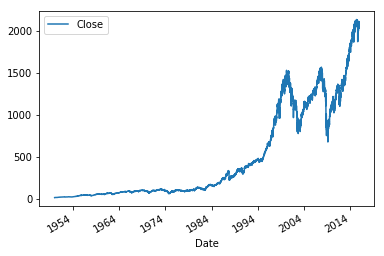

In [6]:
data.plot('Date', 'Close')

In [7]:
data.Close.describe()

count    16590.000000
mean       482.692491
std        555.007904
min         16.660000
25%         83.860001
50%        144.264999
75%        950.797500
max       2130.820068
Name: Close, dtype: float64

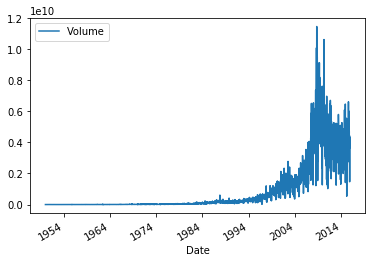

In [8]:
data.plot('Date', 'Volume')

## Generating Indicators
In this case, might be useful to have the trailing five day, month and yearly averages of closing price. Note the point that you can't have the day's closing price in the calculation; would be an example of data leakage. Could be done with a built in function, of couse, see [rolling_mean][1] but the idea here is to practice. 

[1]:http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html

Let's start with the five day moving average. Of course, we're talking about five trading days. One approach could be to simply look at the preceeding 5 rows using the index as a guide. 

In [9]:
data = data.reset_index(drop=True)

In [10]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
2,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
3,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
4,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


But, how do pass a set of rows to a function? Looks like the [iterrows](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.iterrows.html) function can help. 

In [11]:
testdata = data[0:10].copy()
testdata['last_5_avg']=0
for index, row in testdata.iterrows():
    last_five = []
    
    for i in range(1,6):
        if index-i > 0:
            last_five.append(testdata.iloc[index-i, 4])
        else:
            last_five.append(np.nan)
    
    testdata.iloc[index, 7]= np.mean(last_five)

testdata

,Date,Open,High,Low,Close,Volume,Adj Close,last_5_avg
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,NaN
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926


Could you just make a general function?

In [12]:
def trailing_avg(xSeries, days):
    trailingavg = []
    
    for index in range(0, len(xSeries)):
        last_n = []
        
        for i in range(1,days+1):
            if index - i >= 0:
                last_n.append(xSeries[index-i])
            else:
                last_n.append(np.nan)
        
        trailingavg.append(np.mean(last_n))
            
    return trailingavg

In [13]:
testSeries = data.Close[0:10].copy()

temp = trailing_avg(testSeries, 5)

print(temp)

testdata['last_five_avg2'] = temp

testdata

[nan, nan, nan, nan, nan, 16.899999999999999, 16.974000199999999, 17.022000200000001, 16.988000200000002, 16.926000200000001]


,Date,Open,High,Low,Close,Volume,Adj Close,last_5_avg,last_five_avg2
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,NaN,16.900
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,16.974
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,17.022
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,16.988
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,16.926


Seems to work. So let's apply to the dataset now. 

In [14]:
data['last_5_avg'] = trailing_avg(data.Close, 5)
data['last_30_avg'] = trailing_avg(data.Close, 30)
data['last_365_avg'] = trailing_avg(data.Close, 365)
data['ratio_last5_last365'] = data.last_30_avg/data.last_365_avg
data.sample(10)

,Date,Open,High,Low,Close,Volume,Adj Close,last_5_avg,last_30_avg,last_365_avg,ratio_last5_last365
6986,1977-11-10,92.980003,95.099998,92.690002,94.709999,3.198000e+07,94.709999,92.014001,93.434666,100.586192,0.928902
16489,2015-07-16,2110.550049,2124.419922,2110.550049,2124.290039,3.227080e+09,2124.290039,2088.776025,2091.925688,1993.239618,1.049510
14793,2008-10-17,942.289978,984.640015,918.739990,940.549988,6.581780e+09,940.549988,950.969995,1128.183004,1391.745917,0.810624
4867,1969-06-23,96.669998,97.169998,95.209999,96.230003,1.290000e+07,96.230003,97.597998,102.305333,99.197945,1.031325
5041,1970-03-03,89.709999,90.669998,88.959999,90.230003,1.170000e+07,90.230003,89.089999,87.598667,98.027562,0.893613
8112,1982-04-28,117.830002,118.050003,116.940002,117.260002,5.053000e+07,117.260002,117.762001,114.428334,125.711342,0.910247
7456,1979-09-21,110.510002,111.580002,109.459999,110.470001,5.238000e+07,110.470001,108.878000,108.168000,100.348822,1.077920
12414,1999-05-05,1332.000000,1347.319946,1317.439941,1347.310059,9.135000e+08,1347.310059,1343.110010,1323.910999,1120.538685,1.181495
4354,1967-04-28,93.809998,94.769997,93.330002,94.010002,1.120000e+07,94.010002,92.972000,90.677333,86.383562,1.049706
13290,2002-10-29,890.229980,890.640015,867.909973,882.150024,1.529700e+09,882.150024,891.335998,847.328003,1076.204796,0.787330


To replicate what I've done with the means for standard deviations, let's learn how to use the rolling function. Might be good to test how it works on the last five mean which I've already done. Note that we need to shift the data in the column down 1 so that the average reflects teh sum of the last 5 days before today rather than the last five including today. Again, this is the data leak issue. 

In [15]:
testdf = data[0:20].copy()
testdf['test_last5_avg'] = testdf.Close.rolling(5).mean().shift(1)
testdf[['Date', 'Close', 'last_5_avg', 'test_last5_avg']]

,Date,Close,last_5_avg,test_last5_avg
0,1950-01-03,16.660000,NaN,NaN
1,1950-01-04,16.850000,NaN,NaN
2,1950-01-05,16.930000,NaN,NaN
3,1950-01-06,16.980000,NaN,NaN
4,1950-01-09,17.080000,NaN,NaN
5,1950-01-10,17.030001,16.900,16.900
6,1950-01-11,17.090000,16.974,16.974
7,1950-01-12,16.760000,17.022,17.022
8,1950-01-13,16.670000,16.988,16.988
9,1950-01-16,16.719999,16.926,16.926


Ok, so I think I understand how this works. Let's do the standard deviation columns: 
- last 5 trailing std dev
- last 30
- last 365
- ratio of last 5 stdev and last 365

In [16]:
data['last_5_std'] = data.Close.rolling(5).std().shift(1)
data['last_30_std'] = data.Close.rolling(30).std().shift(1)
data['last_365_std'] = data.Close.rolling(365).std().shift(1)
data['ratio_last5_last365_std'] = data.last_5_std/data.last_365_std

data.sample(10)

,Date,Open,High,Low,Close,Volume,Adj Close,last_5_avg,last_30_avg,last_365_avg,ratio_last5_last365,last_5_std,last_30_std,last_365_std,ratio_last5_last365_std
3379,1963-06-14,70.230003,70.599998,69.870003,70.250000,3.840000e+06,70.250000,70.204002,70.220000,63.883315,1.099192,0.215362,0.316522,5.350244,0.040253
4219,1966-10-13,77.040001,78.449997,76.220001,76.889999,8.680000e+06,76.889999,74.746001,76.987667,87.503041,0.879828,1.432701,1.764767,4.720771,0.303489
6969,1977-10-18,93.470001,94.190002,93.010002,93.459999,2.013000e+07,93.459999,93.892000,95.742666,101.007260,0.947879,0.627352,1.126178,2.943747,0.213113
10267,1990-11-02,307.019989,311.940002,306.880005,311.850006,1.687000e+08,311.850006,304.333997,306.904668,338.331644,0.907112,1.841510,5.567036,15.580887,0.118190
12022,1997-10-13,966.979980,973.460022,966.950012,968.099976,3.548000e+08,968.099976,973.450000,944.171000,775.774165,1.217069,6.002262,19.906386,101.053328,0.059397
13791,2004-10-26,1094.810059,1111.099976,1094.810059,1111.089966,1.685400e+09,1111.089966,1100.784009,1117.084676,1074.581781,1.039553,5.197654,12.234230,59.382604,0.087528
5560,1972-03-17,107.500000,108.610001,106.889999,107.919998,1.604000e+07,107.919998,107.714000,106.429666,97.364329,1.093107,0.402776,1.484085,6.199532,0.064969
12168,1998-05-13,1115.790039,1122.219971,1114.930054,1118.859985,6.000100e+08,1118.859985,1106.126026,1111.569006,909.578879,1.222070,7.413844,11.337729,111.454981,0.066519
10445,1991-07-19,385.380005,385.829987,383.649994,384.220001,1.907000e+08,384.220001,382.146002,377.508666,346.590356,1.089207,1.958883,3.849608,24.753750,0.079135
2705,1960-10-07,54.029999,54.029999,54.029999,54.029999,2.530000e+06,54.029999,53.396001,55.031667,56.974192,0.965905,0.267637,1.654722,1.697234,0.157690


Note how much faster the rolling function is than your loop implementation above!

## Remove Rows with Missing Values

In [17]:
# all rows before 1951-01-03 will have missing values for last_365
print('Shape of Data before:', data.shape)
data  = data[data.Date > '1951-01-03']
print('Shape of Data after:', data.shape)


Shape of Data before: (16590, 15)
Shape of Data after: (16339, 15)


In [18]:
# drop remaining rows with missing values
print('Shape of Data before:', data.shape)
data = data.dropna(axis=0)
print('Shape of Data after:', data.shape)

Shape of Data before: (16339, 15)
Shape of Data after: (16225, 15)


## Split Data into Training and Test Sets

In [19]:
# Picking Jan 1, 2013 as the cutoff point 
train = data[data.Date<'2013-01-01']
print('Shape of train:', train.shape)
test = data[data.Date>='2013-01-01']
print('Shape of test:', test.shape)

Shape of train: (15486, 15)
Shape of test: (739, 15)


## Linear Regression Model

In [20]:
#only use the new indicators for features
features = [col for col in data if (col.startswith('last') | col.startswith('ratio'))]
print('Features:', features)
target = ['Close']
print('Target:', target)

#instantiate model
model = LinearRegression()

#train
model.fit(train[features], train[target])

#test
predictions = model.predict(test[features])

#validate
rmse = mean_squared_error(test[target], predictions)**.5

print(rmse)

Features: ['last_5_avg', 'last_30_avg', 'last_365_avg', 'ratio_last5_last365', 'last_5_std', 'last_30_std', 'last_365_std', 'ratio_last5_last365_std']
Target: ['Close']
22.20625461


### Visually Inspect the Predictions and Test Data

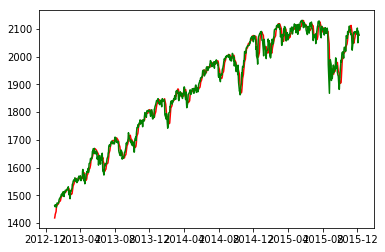

In [21]:
plt.plot(test.Date, predictions, color = 'red')
plt.plot(test.Date, test.Close, color = 'green')
plt.show()

## Conclusions

Not too bad actually. Given that the mean close is about 493. Being off by about 20 is less than 5% error.